# Predicting used car value using log prices

using the used-cars dataset

In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from plotnine import *
from stargazer import stargazer
from statsmodels.tools.eval_measures import mse, rmse

warnings.filterwarnings("ignore")
# turning off scientific notation
pd.set_option("display.float_format", lambda x: "%.2f" % x)

In [2]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]

# location folders
data_in = dirname + "da_data_repo/used-cars/clean/"
data_out = dirname + "da_case_studies/ch14-used-cars-log/"
output = dirname + "da_case_studies/ch14-used-cars-log/output/"
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)


In [3]:
# Import the prewritten helper functions
from py_helper_functions import *


In [4]:
# DATA IMPORT
data = pd.read_csv("used-cars_2cities_prep.csv")


In [5]:
# SAMPLE DESIGN

# Manage missing
data["fuel"] = data["fuel"].fillna("Missing")
data["condition"] = data["condition"].fillna("Missing")
data["drive"] = data["drive"].fillna("Missing")
data["cylinders"] = data["cylinders"].fillna("Missing")
data["transmission"] = data["transmission"].fillna("Missing")
data["type"] = data["type"].fillna("Missing")


In [6]:
# drop hybrid models then drop column
data = (data.query("Hybrid==0")).drop(["Hybrid"], axis=1)

# keep gas-fuelled vehicles
data = data.query("fuel=='gas'")

# drop vehicles in fair and new condition, trucks
data = data.query("condition not in ['new','fair']")

# drop unrealistic values for price and odometer reading
data = data.query("price in @seq(500,25001,by=1)").query("odometer<=100")

# drop if price is smaller than 1000 and condition is like new or age is less than 8
data = data.query("~(price < 1000 & (condition == 'like new'|age < 8))")

data = data.query("~(transmission=='manual')")

# drop if truck
data = data.query("~(type=='truck')")

# drop pricestr
data = data.drop(["pricestr"], axis=1)


In [7]:
# DATA GENERATION & DESCRIPTIVES
# CONDITION
data["cond_excellent"] = np.where(data["condition"] == "excellent", 1, 0)
data["cond_good"] = np.where(data["condition"] == "good", 1, 0)
data["cond_likenew"] = np.where(data["condition"] == "like new", 1, 0)
# cylinders
data["cylind6"] = np.where(data["cylinders"] == "6 cylinders", 1, 0)
data.cylinders.value_counts()
data.cylind6.value_counts()
# age: quadratic, cubic
data["agesq"] = data["age"] ** 2
data["agecu"] = data["age"] ** 3
# odometer quadratic
data["odometersq"] = data["odometer"] ** 3


In [8]:
# focus only on Chicago
data = data.query("area=='chicago'")


### Compare Graphs
#### lowess:price

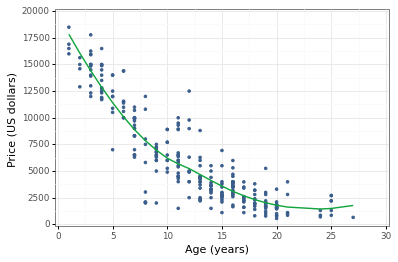

<ggplot: (8783721116385)>

In [9]:
(
    ggplot(data, aes(x="age", y="price"))
    + geom_point(color=color[0], size=1, alpha=0.8, show_legend=False, na_rm=True)
    + geom_smooth(method="loess", color=color[1], se=False, size=0.8, na_rm=True)
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 20000), breaks=seq(0, 20000, 2500)
    )
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 30), breaks=seq(0, 30, 5))
    + labs(x="Age (years)", y="Price (US dollars)")
    + theme_bw()
)


#### lowess: lnprice

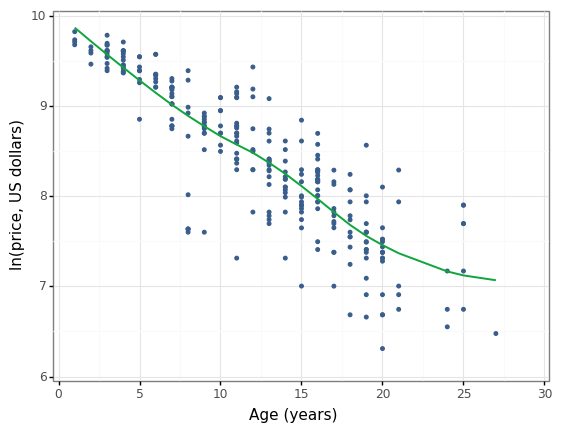

<ggplot: (8783737936473)>

In [10]:
(
    ggplot(data, aes(x="age", y="lnprice"))
    + geom_point(color=color[0], size=1, alpha=0.8, show_legend=False, na_rm=True)
    + geom_smooth(method="loess", color=color[1], se=False, size=0.8, na_rm=True)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 30), breaks=seq(0, 30, 5))
    + scale_y_continuous(expand=(0.01, 0.01), limits=(6, 10), breaks=seq(6, 10, 1))
    + labs(x="Age (years)", y="ln(price, US dollars)")
    + theme_bw()
)


---
### Linear regressions

In [11]:
model1 = "lnprice ~ age + agesq"
model2 = "lnprice ~ age + agesq + odometer"
model3 = "lnprice ~ age + agesq + odometer + odometersq + LE + cond_excellent + cond_good + dealer"
model4 = "lnprice ~ age + agesq + odometer + odometersq + LE + XLE + SE + cond_likenew + cond_excellent + cond_good + cylind6 + dealer"
model5 = "lnprice ~ age + agesq + odometer + odometersq + LE * age + XLE * age + SE * age + cond_likenew * age + cond_excellent * age + cond_good * age + cylind6 * age + odometer * age + dealer * age"

model_equations = [model1, model2, model3, model4, model5]

In [12]:
models = []
for equation in model_equations:
    models.append(smf.ols(equation, data).fit(cov_type="HC1"))

Use custom function `ols_crossvalidator`

In [13]:
help(ols_crossvalidator)

Help on function ols_crossvalidator in module py_helper_functions:

ols_crossvalidator(formula: str, data: pandas.core.frame.DataFrame, n_folds=5, average_rmse=True) -> dict
    OLS cross-validator
    
    
    Estimates `formula` equation with OLS and returns values of RMSE, R`2, No. coefficients,
    BIC on `data`. Does k-fold cross-validation and either returns train and test RMSE for each
    fold, or return averarage train and test RMSEs.
    
    Parameters
    ----------
    formula : str
        Equation that is estimated by OLS.
    data : pd.DataFrame
        Database in a wide format.
    n_folds : int, default=5
        Number of folds. Must be at least 2.
    average_rmse : bool, default=True
        Whether to return the average train and test RMSE of the k-fold CV, or return
        train and test RMSE-s for each fold.



Set n_fold = 4 for 4-fold cross-validation

In [14]:
n_fold = 4

In [15]:
cv_list = []
for equation in model_equations:
    cv_list.append(ols_crossvalidator(equation, data, n_fold, average_rmse=False))

Get statistics for models fitted on the whole dataframe

In [16]:
(
    pd.DataFrame(cv_list)
    .round(2)
    .assign(
        RMSE=lambda x: x["RMSE"],
        BIC=lambda x: x["BIC"].astype(int),
        Coefficients = lambda x: x["Coefficients"].astype(int),
        Model=["Model " + str(i + 1) for i in range(len(model_equations))],
        Nvars=[1, 2, 5, 6, 6],
    )
    .filter(["Model", "Nvars", "Coefficients", "R-squared", "RMSE", "BIC"])
    .set_index("Model")
)

,Nvars,Coefficients,R-squared,RMSE,BIC
Model,,,,,
Model 1,1,3,0.77,0.39,288
Model 2,2,4,0.82,0.35,226
Model 3,5,9,0.83,0.34,237
Model 4,6,13,0.84,0.33,246
Model 5,6,22,0.85,0.32,275


Foldwise test RMSE-s

In [17]:
pd.DataFrame(
    [cv["Test RMSE"] for cv in cv_list],
    index=["Model " + str(i + 1) for i in range(len(cv_list))],
    columns=["Fold" + str(i + 1) for i in range(len(cv_list[0]["Test RMSE"]))],
).assign(Average=lambda x: x.mean(axis=1)).T.round(2)

,Model 1,Model 2,Model 3,Model 4,Model 5
Fold1,0.47,0.39,0.38,0.39,0.39
Fold2,0.45,0.48,0.49,0.49,0.53
Fold3,0.39,0.33,0.35,0.34,0.34
Fold4,0.34,0.30,0.30,0.29,0.31
Average,0.41,0.37,0.38,0.38,0.39


### Prediction
---

In [18]:
new = pd.DataFrame(
    pd.Series(
        {
            "age": 10,
            "agesq": 10**2,
            "odometer": 12,
            "odometersq": 12**2,
            "SE": 0,
            "LE": 1,
            "XLE": 0,
            "cond_likenew": 0,
            "cond_excellent": 1,
            "cond_good": 0,
            "dealer": 0,
            "price": np.nan,
            "cylind6": 0,
        }
    )
).T
new


,age,agesq,odometer,odometersq,SE,LE,XLE,cond_likenew,cond_excellent,cond_good,dealer,price,cylind6
0,10.00,100.00,12.00,144.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,NaN,0.00


Use custom function `point_predict_with_conf_int` to extract point and interval prediction for a new datapoint.


In [19]:
help(point_predict_with_conf_int)

Help on function point_predict_with_conf_int in module py_helper_functions:

point_predict_with_conf_int(regression: statsmodels.regression.linear_model.RegressionResultsWrapper, new_datapoint: pandas.core.frame.DataFrame, interval_precision=0.95, round_n=2) -> dict
    Does point prediction and interval prediction for a new datapoint.
    
        Parameters
    ----------
    regression : statsmodels.regression.linear_model.RegressionResultsWrapper
        Fitted regression model.
    new_datapoint : pd.DataFrame
        Database containing a new observation.
    interval_precision : float, default=0.95
        Precision of interval prediction.
    round_n: int, default=2
        Decimals to round floats in output.



In [20]:
reg3 = models[2]

In [21]:
prediction = pd.DataFrame(
    [
        point_predict_with_conf_int(reg3, new, interval_precision=0.8),
    ],
    index=["Model in logs"],
).T

To recalculate predictions to level, we need to extract the rmse

In [22]:
rmse3 = rmse(reg3.fittedvalues, data["lnprice"])

Prediction in levels

In [23]:
log_point_prediction_new = prediction.loc["Point prediction"].values[0]

In [24]:
level_point_prediction_new = np.exp(log_point_prediction_new) * np.exp(rmse3**2 / 2)

Prediction interval (log and level)

In [25]:
intervals = prediction.loc["Prediction Interval (80%)"].values[0]
log_lower_interval_prediction_new = intervals[0]
log_upper_interval_prediction_new = intervals[1]

In [26]:
level_lower_interval_prediction_new = np.exp(
    log_lower_interval_prediction_new
) * np.exp(rmse3**2 / 2)
level_upper_interval_prediction_new = np.exp(
    log_upper_interval_prediction_new
) * np.exp(rmse3**2 / 2)

In [27]:
prediction["Recalculated to level"] = [
    level_point_prediction_new,
    [
        round(level_lower_interval_prediction_new, 2),
        round(level_upper_interval_prediction_new, 2),
    ],
]

Add level model prediction

In [28]:
levelreg3 = smf.ols(model3.replace("ln", ""),data).fit()

In [29]:
prediction["Model in levels"] = point_predict_with_conf_int(levelreg3, new, interval_precision=0.8)

In [30]:
def format_confidence_interval(conf_int, round_n=2):
    """
    Format confidence interval in the form "[a – b]" where a and b are the lower and upper bounds of the interval.

    Parameters:
    conf_int (list): A list containing the lower and upper bounds of the confidence interval.
    round_n (int): Number of decimal places to round the bounds to.

    Returns:
    str: A string containing the formatted confidence interval.
    """
    if len(conf_int) != 2:
        return "N/A"
    elif round_n == 0:
        return "[" + "–".join([str(int(round(i, round_n))) for i in conf_int]) + "]"
    else:
        return "[" + "–".join([str(round(i, round_n)) for i in conf_int]) + "]"


In [31]:
prediction.loc["Prediction Interval (80%)", :] = prediction.loc["Prediction Interval (80%)", :].apply(format_confidence_interval)

### Table 14.1 Prediction with the model in log of $y$

In [32]:
prediction

,Model in logs,Recalculated to level,Model in levels
Point prediction,8.56,5524.49,Point prediction
Prediction Interval (80%),[8.11–9.01],[3522.57–8664.13],N/A
